# Higher-dimensional fitting

## Model

We again consider the sine model with gaussian measurement errors.

$$ y = A_1 \sin\left(2 \pi \left(\frac{t}{P_1} + t_1\right)\right) + B + \epsilon $$

where $\epsilon \sim \mathrm{Normal}(0, \sigma)$

We want to test if there is another sine component present:

$$ y = A_1 \sin\left(2 \pi \left(\frac{t}{P_1} + t_1\right)\right) + A_2 \sin\left(2 \pi \left(\frac{t}{P_2} + t_2\right)\right) + B + \epsilon $$



In [9]:
import numpy as np
from numpy import sin, pi

def sine_model1(t, B, A1, P1, t1):
    return A1 * sin((t / P1 + t1) * 2 * pi) + B

def sine_model2(t, B, A1, P1, t1, A2, P2, t2):
    return A1 * sin((t / P1 + t1) * 2 * pi) + A2 * sin((t / P2 + t2) * 2 * pi) + B


The model has four unknown parameters per component:

* the signal offset $B$
* the amplitude $A$
* the period $P$
* the time offset $t_0$

As we will see, the second component makes the 7-dimensional parameter space already quite challenging to explore.

## Generating data

Lets generate some data following this model:


In [10]:

np.random.seed(42)

n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)
# measurement values
yerr = 1.0
y = np.random.normal(sine_model2(t, B=1.0, A1=4.2, P1=3, t1=0, A2=1.2, P2=1.2, t2=1.2), yerr)


## Visualise the data

Lets plot the data first to see what is going on:

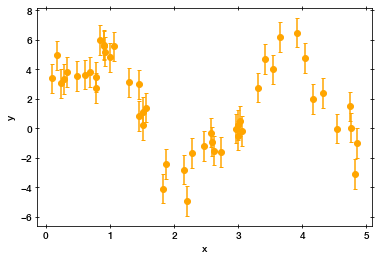

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')
t_range = np.linspace(0, 5, 1000)


A beautiful noisy data set, but we can see the modulation.

Now the question is: what model parameters are allowed under these data?

First, we need to define the parameter ranges through a prior:

In [12]:
parameters1 = ['B', 'A1', 'P1', 't1']

def prior_transform1(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.1 to 100
    params[1] = 10**(cube[1] * 3 - 1)
    # let period go from 0.3 to 30
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]
    return params

parameters2 = ['B', 'A1', 'P1', 't1', 'A2', 'P2', 't2']

def prior_transform2(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.1 to 100
    params[1] = 10**(cube[1] * 3 - 1)
    # let period go from 0.3 to 30
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]

    # let amplitude go from 0.01 to 100
    params[4] = 10**(cube[4] * 3 - 1)
    # let period go from 0.3 to 30
    params[5] = 10**(cube[5] * 2)
    # let time go from 0 to 1
    params[6] = cube[6]
    return params


Define the likelihood, which measures how far the data are from the model predictions.
More precisely, how often the parameters would arise under the given parameters.
We assume gaussian measurement errors of known size (yerr).

$$\chi^2 = \sum\left(\frac{m_i-y_i}{\sigma}\right)^2 $$
$$\log \cal{L} = -\chi^2 / 2$$

where the model is the sine_model function from above at time $t_i$.

In [13]:
import scipy.stats

def log_likelihood1(params):
    # unpack the current parameters:
    B, A1, P1, t1 = params

    # compute for each x point, where it should lie in y
    y_model = sine_model1(t, B=B, A1=A1, P1=P1, t1=t1)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()
    
    return loglike

def log_likelihood2(params):
    # unpack the current parameters:
    B, A1, P1, t1, A2, P2, t2 = params
    
    # avoid unnecessary multiple solutions:
    #    force ordering by period from large to small
    if P1 < P2:
        return -1e300
    
    # compute for each x point, where it should lie in y
    y_model = sine_model2(t, B=B, A1=A1, P1=P1, t1=t1, A2=A2, P2=P2, t2=t2)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()
    
    return loglike
    

Solve the problem:

In [14]:
import ultranest

sampler1 = ultranest.ReactiveNestedSampler(
    parameters1, 
    log_likelihood1, prior_transform1,
    wrapped_params=[False, False, False, True],
)

sampler2 = ultranest.ReactiveNestedSampler(
    parameters2,
    log_likelihood2,
    prior_transform2,
    wrapped_params=[False, False, False, True, False, False, True],
)

First, we solve the simpler model:

In [15]:
result1 = sampler1.run(min_num_live_points=400)
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-35.7627..-35.7623]*| it/evals=8480/59249 eff=14.4098% N=400    0 0  
[ultranest] Likelihood function evaluations: 59322
[ultranest]   logZ = -52.38 +- 0.1759
[ultranest] Effective samples strategy satisfied (ESS = 2137.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.

logZ = -52.389 +- 0.404
  single instance: logZ = -52.389 +- 0.192
  bootstrapped   : logZ = -52.381 +- 0.404
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    B                   : 0.42  │ ▁▁▁▁▁▁▁▁▁▂▂▂▃▃▅▅▅▆▆▇▆▅▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁ │1.63      1.04 +- 0.15
    A1                  : 3.02  │ ▁ ▁▁▁▁▁▁▁▁▂▃▃▃▄▅▆▇▇▇▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁ │4.76      3.94 +- 0.21
    P1                  : 2.869 

Now lets have a go at the harder problem. We limit the number of evaluations:

In [16]:
result2 = sampler2.run(min_num_live_points=400, max_ncalls=400000)

[ultranest] Sampling 400 live points from prior ...


/home/user/.local/lib/python3.8/site-packages/ultranest-3.3.3-py3.8-linux-x86_64.egg/ultranest/integrator.py:1633: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-4e+01  [-89.9197..-75.4800] | it/evals=2194/402993 eff=0.4985% N=213     
[ultranest] Likelihood function evaluations: 402993


/home/user/.local/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[ultranest] Reached maximum number of likelihood calls (402993 > 400000)...
[ultranest] done iterating.


The efficiency is very low. This is not just because of the dimensionality of the problem, but also because of the degeneracies.

To make progress in high-dimensional or otherwise tricky problems, a step sampler can be used.

## Step samplers in UltraNest

To find a replacement live point, step samplers perform a random walk in parameter space. After a number of steps (nsteps), the final point is declared a "independent" sample.

There are several step samplers available. Here we will use a [SliceSampler](https://johannesbuchner.github.io/UltraNest/ultranest.html#ultranest.stepsampler.SliceSampler).


In [19]:
import ultranest.stepsampler

# have to choose the number of steps the slice sampler should take
# after first results, this should be increased and checked for consistency.

nsteps = 2 * len(parameters2)
# create step sampler:
sampler2.stepsampler = ultranest.stepsampler.SliceSampler(
    nsteps=nsteps,
    generate_direction=ultranest.stepsampler.generate_mixture_random_direction,
    # adaptive_nsteps=False,
    # max_nsteps=400
)

# run again:
result2 = sampler2.run(min_num_live_points=400)
sampler2.print_results()

[ultranest] Widening roots to 400 live points (have 400 already) ...


[ultranest] Explored until L=-2e+01   [-19.8295..-19.8288]*| it/evals=6503/659654 eff=1.6785% N=213 
[ultranest] Likelihood function evaluations: 660367


/home/user/.local/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[ultranest]   logZ = -45.36 +- 0.2433
[ultranest] Effective samples strategy satisfied (ESS = 1522.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 211 minimum live points (dlogz from 0.20 to 0.57, need <0.5)
[ultranest]   logZ error budget: single: 0.33 bs:0.24 tail:0.01 total:0.24 required:<0.50
[ultranest] done iterating.

logZ = -45.419 +- 0.572
  single instance: logZ = -45.419 +- 0.237
  bootstrapped   : logZ = -45.360 +- 0.572
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    B                   : 0.33  │ ▁▁▁▁▃▅▇▇▇▅▂▁▁▁▁                     ▁ │3.44      1.01 +- 0.16
    A1                  : 0.10  │▁                ▁      ▁▁▁▂▄▅▇▇▄▂▁▁▁▁ │5.31      4.19 +- 0.24
    P1                  : 1.0   │▇▁▁                     ▁            ▁ │87.2      3.1 +- 1.2
    t1                  : 0.000 │▇▄▁▁              ▁▁               

The efficiency is now constant, and proportional to 1/nsteps.

## Plot the parameter posterior probability distribution

A classic corner plot:

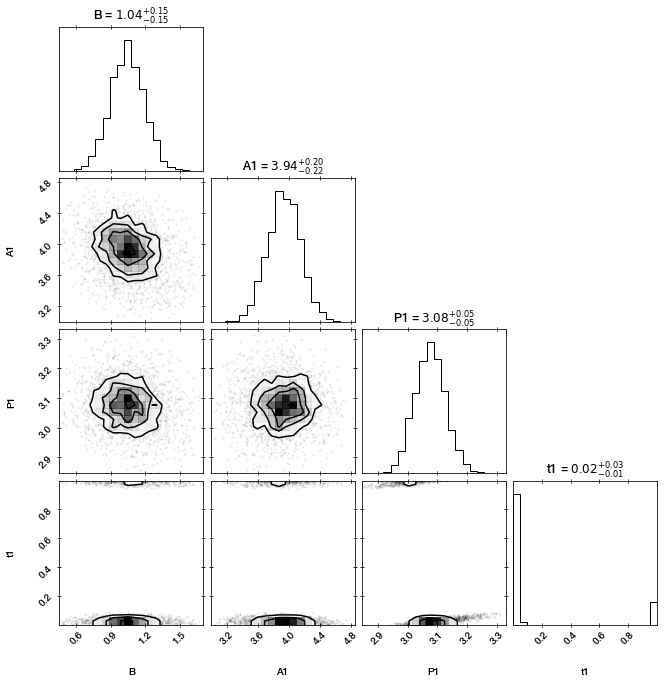

In [20]:
from ultranest.plot import cornerplot
cornerplot(result1)

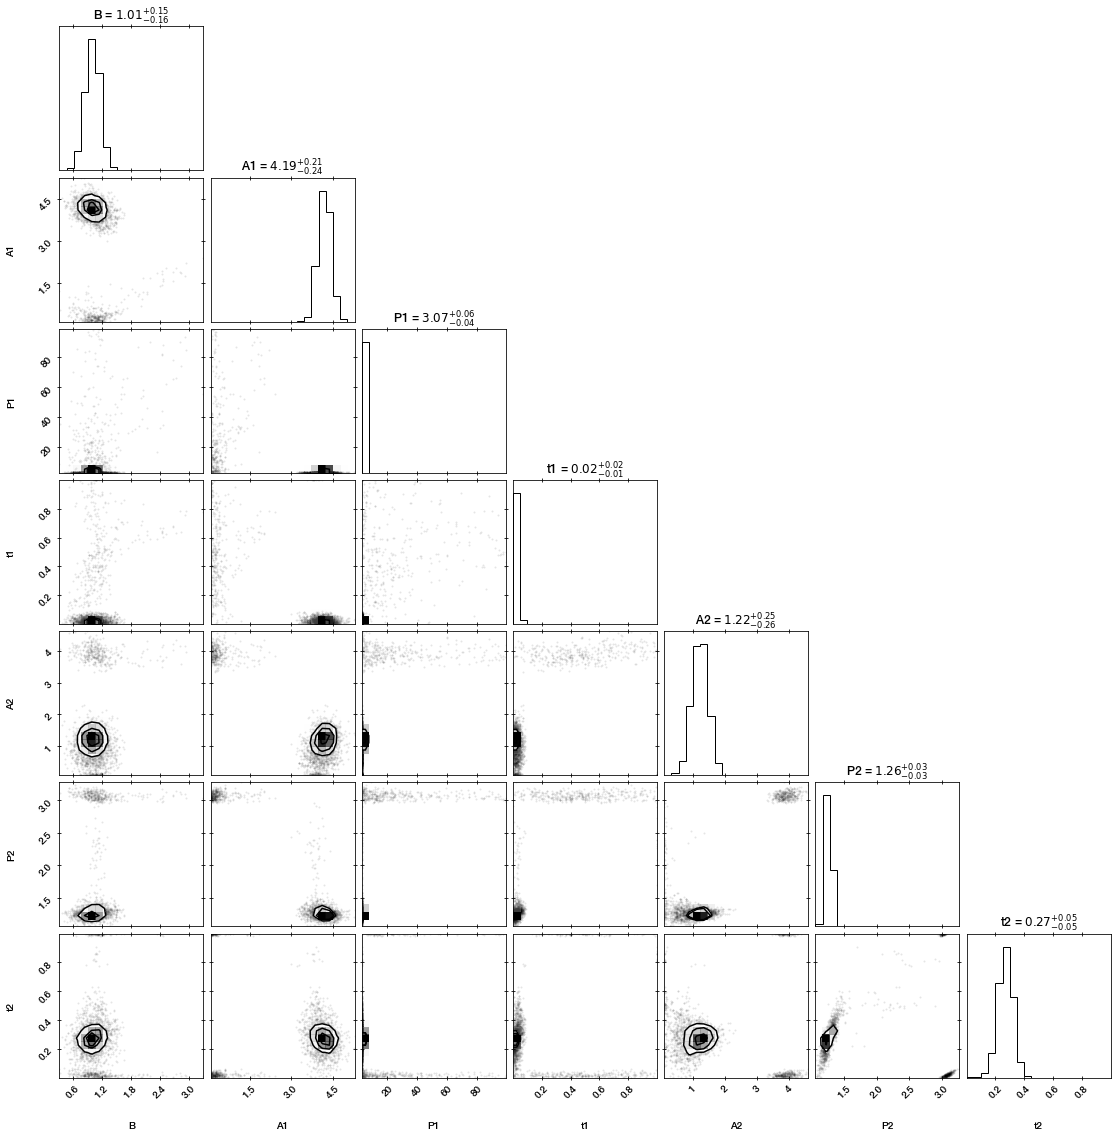

In [21]:
cornerplot(result2)

In [22]:
sampler1.ncall

59322

## Plot the fit

To evaluate whether the results make any sense, we want
to look whether the fitted function goes through the data points.

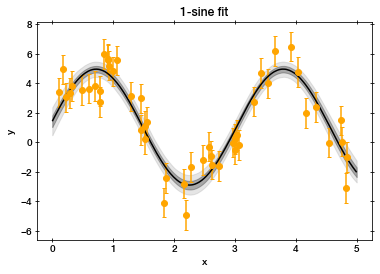

In [23]:
plt.figure()
plt.title("1-sine fit")
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')


t_grid = np.linspace(0, 5, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for B, A1, P1, t1 in sampler1.results['samples']:
    # compute for each time the y value
    band.add(sine_model1(t_grid, B=B, A1=A1, P1=P1, t1=t1))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)



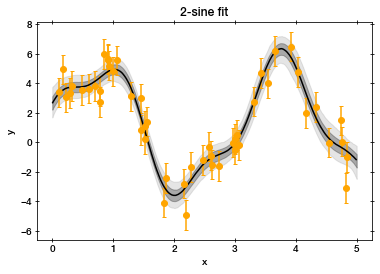

In [24]:
plt.figure()
plt.title("2-sine fit")
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')

band = PredictionBand(t_grid)

# go through the solutions
for B, A1, P1, t1, A2, P2, t2 in sampler2.results['samples']:
    # compute for each time the y value
    band.add(sine_model2(t_grid, B=B, A1=A1, P1=P1, t1=t1, A2=A2, P2=P2, t2=t2))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)





## Model comparison

We now want to know:

**Is the model with 2 components better than the model with one component?**

What do we mean by "better" ("it fits better", "the second component is significant")?

a) Which model is better at predicting data it has not seen yet?

b) Which model is more probably the true one, given this data, and these models (and their parameter spaces)?

c) Which model is simplest, but complex enough to capture the information complexity of the data?


## Bayesian model comparison

Here we will focus on b, and apply Bayesian model comparison. 

For simplicity, we will assume equal a-prior model probabilities.

The Bayes factor is:


In [25]:
K = np.exp(result2['logz'] - result1['logz'])
K

1064.3857030391894

This tells us, assuming both models are equally probable a-priori, that 
the 2-sine model is 150 times more probable to be the true model than the 1-sine model.

N.B.: Bayes factors are influenced by parameter and model priors. It is a good idea to vary them and see how sensitive the result is. Here, the factor is extremely large, so we can be fairly confident that the 2-sine model is correct.

For making decisions, thresholds are needed. They can be calibrated to desired low false decisions rates with simulations (generate data under the simpler model, look at K distribution).